In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Proposal Presentation TS Modeling

Working on some graphics for the proposal presentation using AQI data from Florida (2017-2018). Univariate time series for simplicity and exposition.

See Kaggle .ipynb here: https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python
See Towards Data Science here: https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000


In [1]:
dat = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/CSE 5819/Data/aqi_sample_data_wakulla_florida_bdate_20170101_edate_20191231_wind_speed_dir.csv")
dat.head(5)

NameError: ignored

In [ ]:
df_ts = dat[["datetime_gmt", "sample_measurement_64101"]]
df_ts["datetime_gmt"] = pd.to_datetime(df_ts["datetime_gmt"])
df_ts.rename(columns = {"datetime_gmt": "datetime", "sample_measurement_64101": "air_pressure"}, inplace = True)
df_ts = df_ts.loc[~df_ts.air_pressure.isna(),:]
df_ts.set_index("datetime")

df_ts.fillna(method = "pad", inplace = True)
df_ts = df_ts.dropna()
print(df_ts.shape)
df_ts.head(5)

(12453, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,datetime,air_pressure
0,2018-01-01 04:00:00,1020.0
1,2018-01-01 03:00:00,1020.0
2,2018-01-01 02:00:00,1020.0
3,2018-01-01 01:00:00,1020.0
4,2018-01-01 00:00:00,1019.0


Quick plot of the whole time series.

Text(0.5, 1.0, 'Air Pressure in Wakulla County FL (2017-2018)')

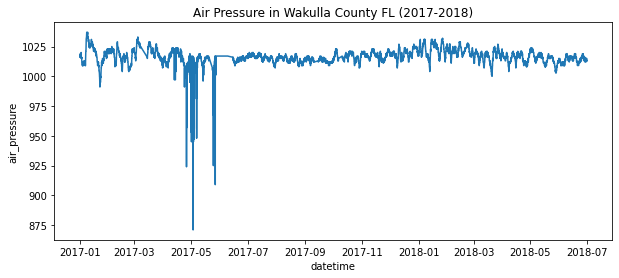

In [ ]:
plt.figure(figsize = (10,4))
sns.lineplot(x = "datetime", y = "air_pressure", data = df_ts)
plt.title("Air Pressure in Wakulla County FL (2017-2018)")

A quick look at the seasonal trends decomposed multiplicatively and additively.

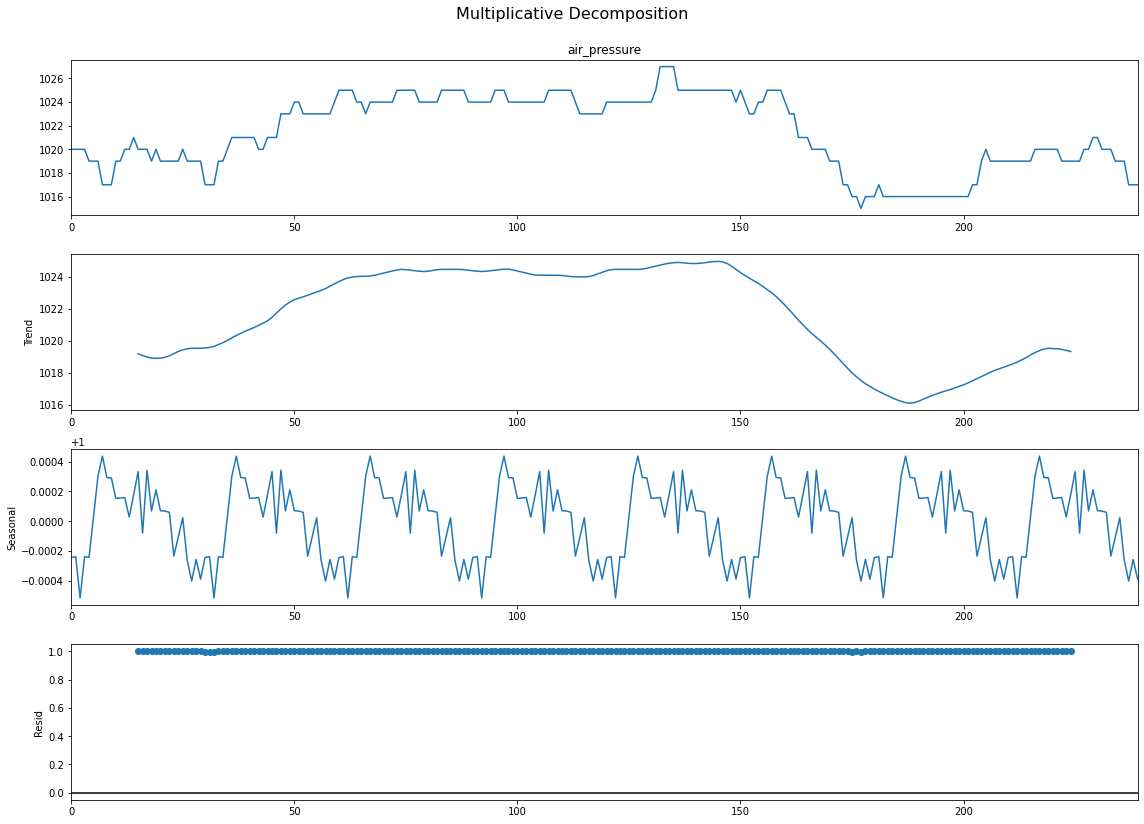

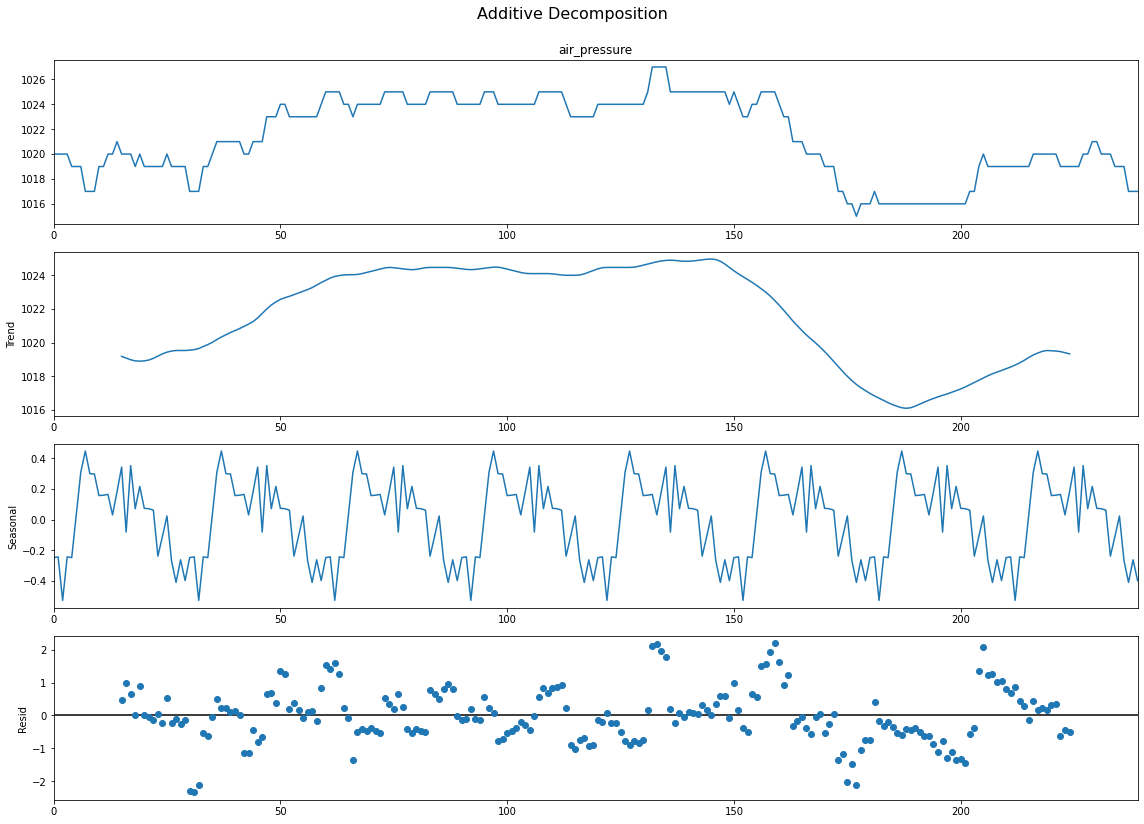

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_ts.air_pressure[0:240], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_ts.air_pressure[0:240], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Now for actually modeling the time series. First detrended to get closer to stationarity.

Text(0.5, 1.0, 'Air Pressure detrended by Subtracting the Least Squares Fit')

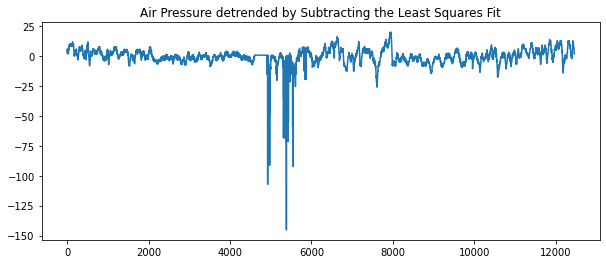

In [ ]:
from scipy import signal

detrended = signal.detrend(df_ts["air_pressure"].values)
plt.figure(figsize = (10,4))
plt.plot(detrended)
plt.title("Air Pressure detrended by Subtracting the Least Squares Fit")

Text(0.5, 1.0, 'Air Pressure detrended by subtracting the trend component')

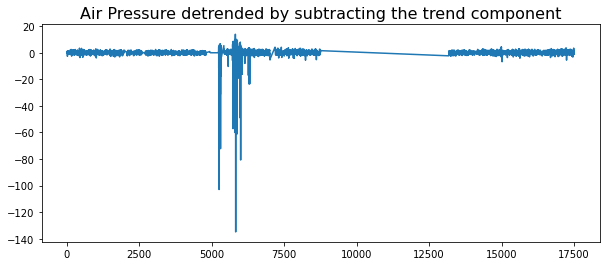

In [ ]:
# Using statmodels: Subtracting the Trend Component
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(df_ts['air_pressure'], model='multiplicative', period=30)
detrended = df_ts['air_pressure'].values - result_mul.trend
plt.figure(figsize = (10,4))
plt.plot(detrended)
plt.title('Air Pressure detrended by subtracting the trend component', fontsize=16)

In [ ]:
detrended.dropna(inplace = True)

Here's a look at autocorrelation plots (ACF) which help us determine if there's still a seasonal trend.

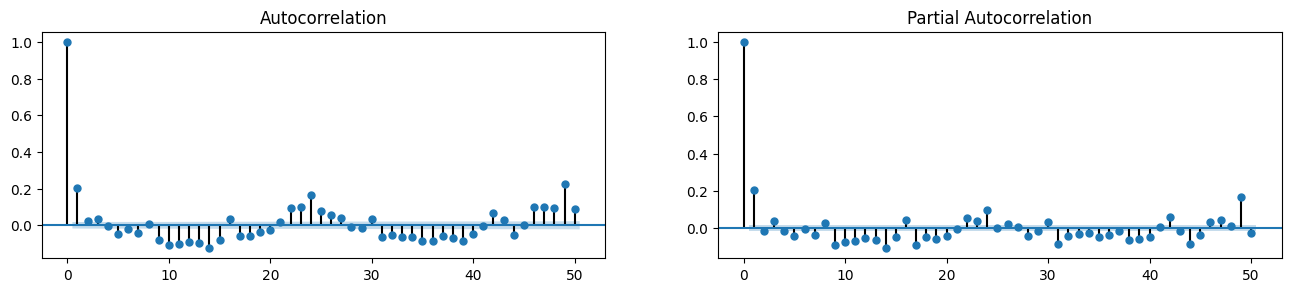

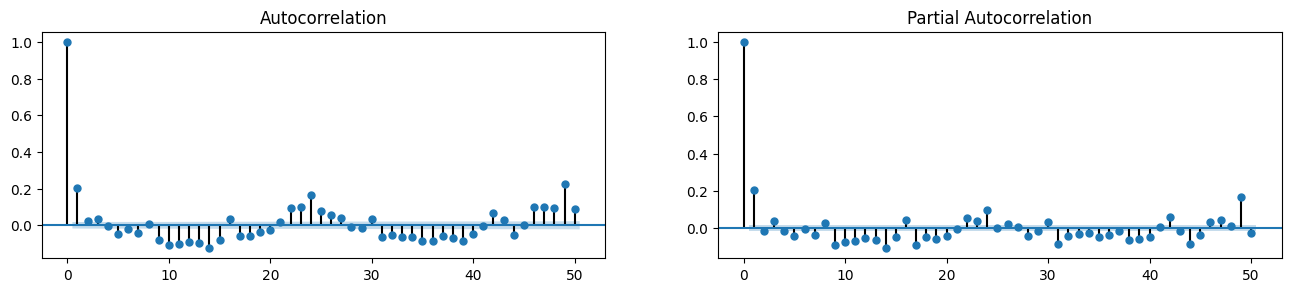

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(detrended, lags=50, ax=axes[0])
plot_pacf(detrended, lags=50, ax=axes[1])

Here's a quick ARIMA model.

In [ ]:
print(df_ts.air_pressure.shape)
train = df_ts.air_pressure[0:9999]
test = df_ts.air_pressure[10000:12452]
print(train.shape)
test.shape

(12453,)
(9999,)


(2452,)

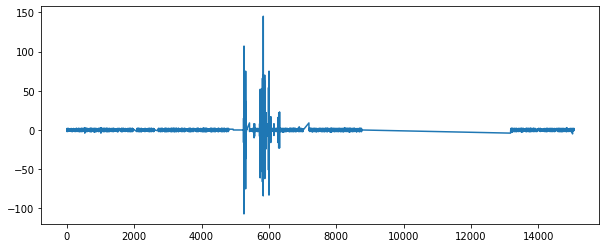

In [ ]:
ts_diff = train - train.shift()
ts_diff = ts_diff.dropna()

plt.figure(figsize = (10,4))
plt.plot(ts_diff)

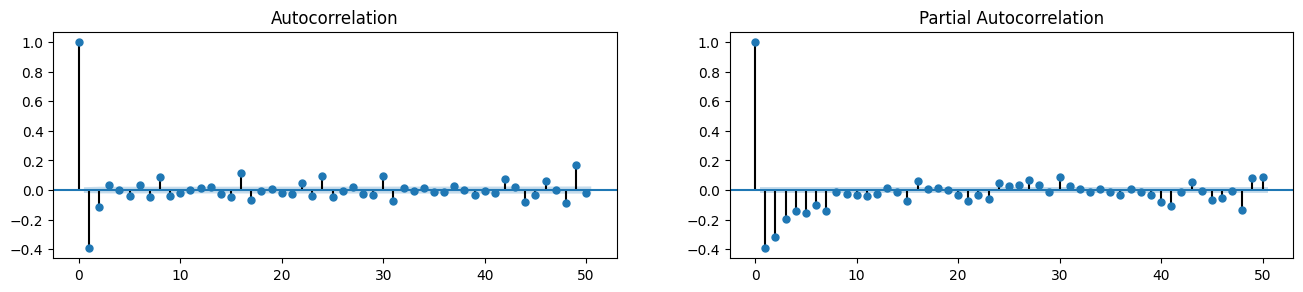

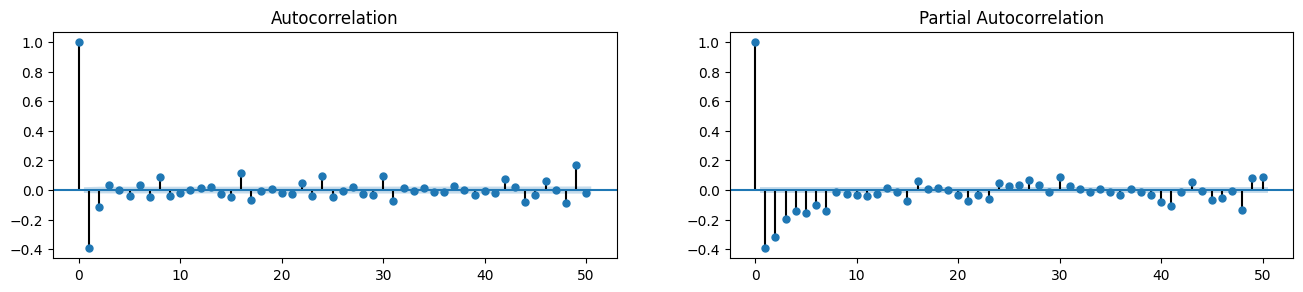

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(ts_diff, lags=50, ax=axes[0])
plot_pacf(ts_diff, lags=50, ax=axes[1])

There's spikes in the ACF plots at 12 and 24 indicating an AR component of 12 or 24. There's somewhat of a sine pattern in the PACF and it leaves the band at q = 8.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order = (12, 1, 8))

results_ARIMA = model.fit()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Text(0.5, 1.0, 'Out of Sample Forecast (100 time-steps)')

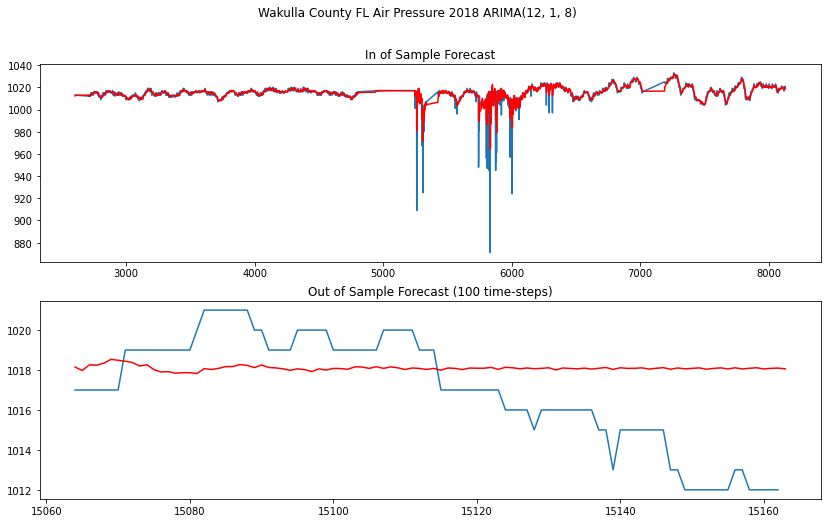

In [ ]:
pred_test = results_ARIMA.forecast(steps = 100)
pred_test

fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (14, 8))
fig.suptitle('Wakulla County FL Air Pressure 2018 ARIMA(12, 1, 8)')

axs[0].plot(train[2500:7500])
axs[0].plot(results_ARIMA.fittedvalues[2500:7500], color = "red")
axs[0].set_title('In of Sample Forecast')
axs[1].plot(test[0:99].index, test[0:99])
axs[1].plot(test[0:100].index, pred_test, color = "red")
axs[1].set_title('Out of Sample Forecast (100 time-steps)')

Next I'll do a SARIMA model that includes a seasonal trend. Here seasonal means daily (24 hr) trend.

In [ ]:

model2 = ARIMA(train, order = (12, 1, 8), seasonal_order = (1,1,0,24))

results_SARIMA = model2.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Text(0.5, 1.0, 'Out of Sample Forecast')

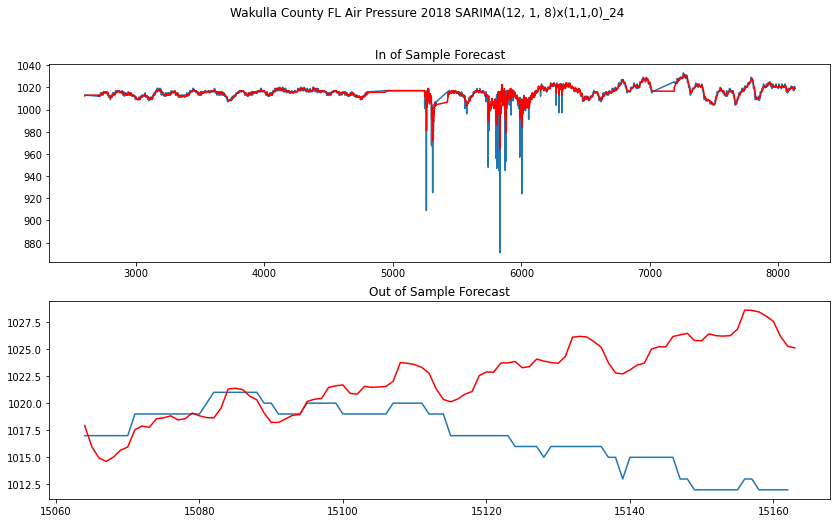

In [ ]:
pred_test = results_SARIMA.forecast(steps = 100)
pred_test

fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (14, 8))
fig.suptitle('Wakulla County FL Air Pressure 2018 SARIMA(12, 1, 8)x(1,1,0)_24')

axs[0].plot(train[2500:7500])
axs[0].plot(results_ARIMA.fittedvalues[2500:7500], color = "red")
axs[0].set_title('In of Sample Forecast')
axs[1].plot(test[0:99].index, test[0:99])
axs[1].plot(test[0:100].index, pred_test, color = "red")
axs[1].set_title('Out of Sample Forecast')